In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import CLB.CLBXMLWriter as CLBXML   
import tempfile
import scipy.optimize as so
from display_xml import XML

from scipy.integrate import solve_ivp

# First shot: spatially variable SIR model with uniform IC

To evaluate, if model is working, let's start with basic case: uniform initial distribution of SIR variables, with periodic BC. This should give solution for original SIR ODE, if $\beta$ is sufficiently large.

Firstly, we prepare solution of ODE using SymPy's solve_ivp toolbox. For details see previous workshops.

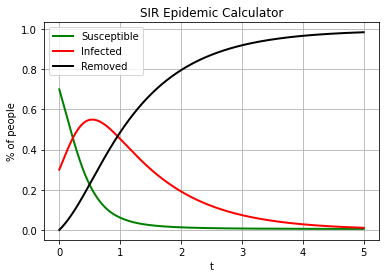

In [2]:
#Test case settings

I_init = 0.3
S_init = 1. - I_init
R_init = 0
Beta = 5
Gamma = 1
T = 5



###########################3
# FD SOLUTION #


def SIR_0D(t, z, beta, gamma, N):
    """
     # Susceptible → Infected → Removed
    :param t: time [days]
    :param z: Susceptible, Exposed, Infected, Removed
    :param beta: average number of contacts per day for each infected individual
    :param gamma: Between I and R, the transition rate is γ
    (simply the frequency of recoveries, that is, number of recovered or dead during one day
    divided by the total number of infected on that same day, supposing "day" is the time unit).
    If the duration of the infection is denoted D, then γ = 1/D.
    :return: derivatives [dS, dI, dR]
    """

    S, I, R = z
    dSdt = -beta*I*S/N
    dIdt = beta*I*S/N - I*gamma
    dRdt = I*gamma
    return [dSdt, dIdt, dRdt]



# INITIAL CONDItIONS
initial_susceptible = S_init # initial number of susceptible individuals in population.
initial_infections = I_init  # initial number of infected individuals in population.
initial_removed = R_init  # initial number of removed (recovered) individuals in population.
IC = np.array([initial_susceptible, initial_infections, initial_removed])

days_to_simulate = T
sol = solve_ivp(SIR_0D,
                [0, days_to_simulate],
                IC,
                method='RK45',
                args=[Beta, Gamma, 1],
                dense_output=True)

t_rk4 = np.linspace(0, days_to_simulate, 1000)
z = sol.sol(t_rk4)

S_rk4, I_rk4, R_rk4 = z

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (14, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
axes = plt.gca()
plt.plot(t_rk4, S_rk4,
         color="green", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Susceptible')
plt.plot(t_rk4, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Infected')
plt.plot(t_rk4, R_rk4,
         color="black", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Removed')


plt.xlabel('t')
plt.ylabel('% of people')
plt.title('SIR Epidemic Calculator')
plt.legend()
plt.grid()

plt.show()

# plt.plot(t_rk4, S_rk4,
#          color="green", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
#          label='S - RK45')
# plt.plot(t_rk4, I_rk4,
#          color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
#          label='I - RK45')
# plt.plot(t_rk4, R_rk4,
#          color="black", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
#          label='R - RK45')
# plt.legend()

We will use **d2q9_reaction_diffusion_system_SIR_ModifiedPeng** model (or the WSIR model), aleready referenced in this workshop

$$
\frac{\partial}{\partial t} W = \beta_W \left[\frac{r^2}{8}W + (I-W) \right] \\
\frac{\partial}{\partial t} S = - \beta \frac{S}{N}W\\
\frac{\partial}{\partial t} I = \beta \frac{S}{N}W - \gamma I \\
\frac{\partial}{\partial t} R = \gamma I
$$


where 

$$
S = ODE_1 \\
I = ODE_2 \\
R = ODE_3 \\
C_1 = R_0 \\
C_2 = \beta\\
C_3 = dt
$$





In [3]:
dt = 0.001

CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', 1)
CLBc.addGeomParam('ny', 1)

Beta_w = 1 / dt

params = {
        "Diffusivity_W" : 1./6.,
        "Beta":Beta * dt,
        "Beta_w":Beta_w * dt,
        "Gamma":Gamma * dt,            
        "Init_W":0, #This is W equation, initlally equall to I. large Beta reduces Relaxation-To-SIR Time
        "Init_S":S_init,
        "Init_I":I_init,
        "Init_R":R_init,
        "Init_N":1
}

CLBc.addModelParams(params)


CLBc.addHDF5()
T_lbm = int(T / dt)
SaveEvery = int(T_lbm / 50)

solve = CLBc.addSolve(iterations=T_lbm)

CLBc.addHDF5(Iterations=SaveEvery, parent=solve)

   
CLBc.write('WSIR-UniformIC.xml')

In [4]:
! tclb d2q9_reaction_diffusion_system_SIR_ModifiedPeng WSIR-UniformIC.xml > /dev/null && echo 'Done'

Hello allocator!
Done


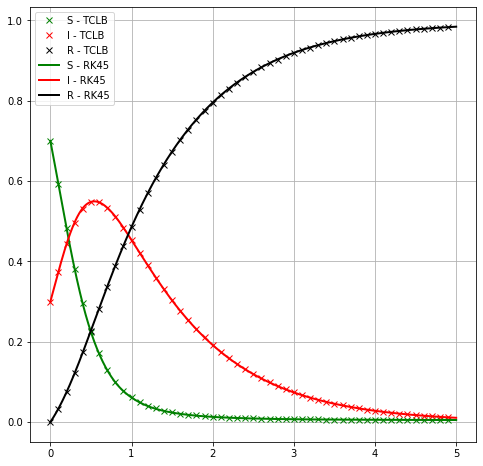

In [5]:
S = list()
I = list()
R = list()
t_lb = list()
for i in range(0,T_lbm,SaveEvery):
    f = h5py.File('output/WSIR-UniformIC_HDF5_%08d.h5'%i)    
    #plt.plot(f['DRE_1'][0,25,:])
    S.append( f['S'][0,0,0] )
    I.append( f['I'][0,0,0] )
    R.append( f['R'][0,0,0] )
    t_lb.append(i)
    
t_lb = np.array(t_lb)*dt
    
    
plt.figure(figsize=(8,8))
    
plt.plot(t_lb,S, 'gx', label='S - TCLB')
plt.plot(t_lb,I, 'rx', label='I - TCLB')
plt.plot(t_lb,R, 'kx', label='R - TCLB')

plt.plot(t_rk4, S_rk4,
         color="green", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='S - RK45')
plt.plot(t_rk4, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='I - RK45')
plt.plot(t_rk4, R_rk4,
         color="black", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='R - RK45')
plt.legend()
plt.grid(which='both')

## We could use TCLB shortcuts in a loop, to see effects of $\beta$

Hello allocator!
DONE!
Hello allocator!
DONE!
Hello allocator!
DONE!
Hello allocator!
DONE!


Text(0, 0.5, '% of population')

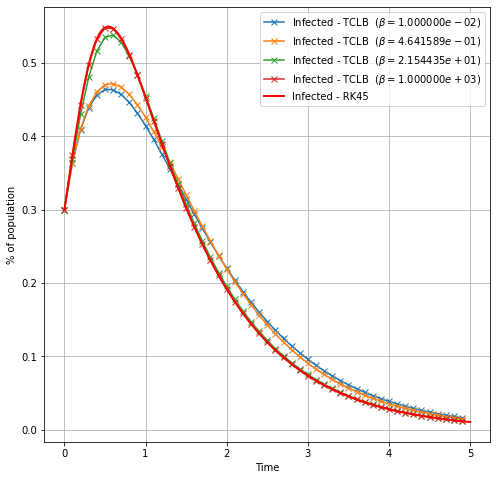

In [6]:
plt.figure(figsize=(8,8))
    
for _beta in np.logspace(-5,0,4):
    
    CLBc = CLBXML.CLBConfigWriter( )

    CLBc.addGeomParam('nx', 1)
    CLBc.addGeomParam('ny', 1)


    params = {
            "Diffusivity_W" : 1./6.,
            "Beta_w": (_beta / dt) * dt,
            "Beta":Beta * dt,
            "Gamma":Gamma * dt,            
            "Init_W":I_init, #This is W equation, initlally equall to I. to ensure that large Beta reduces Relaxation-To-SIR Time
            "Init_S":S_init,
            "Init_I":I_init,
            "Init_R":R_init,
            "Init_N":1
    }

    CLBc.addModelParams(params)


    CLBc.addHDF5()
    solve = CLBc.addSolve(iterations=T_lbm)
    CLBc.addHDF5(Iterations=SaveEvery, parent=solve)

    CLBc.write('WSIR-UniformIC-iterBeta.xml')

    ! rm -rf output/* &&  tclb d2q9_reaction_diffusion_system_SIR_ModifiedPeng WSIR-UniformIC-iterBeta.xml > /dev/null && echo "DONE!"


    S = list()
    I = list()
    R = list()
    t_lb = list()
    for i in range(0,T_lbm,SaveEvery):
        f = h5py.File('output/WSIR-UniformIC-iterBeta_HDF5_%08d.h5'%i)    
        #plt.plot(f['DRE_1'][0,25,:])
        S.append( f['S'][0,0,0] )
        I.append( f['I'][0,0,0] )
        R.append( f['R'][0,0,0] )
        t_lb.append(i)

    t_lb = np.array(t_lb)*dt

    plt.plot(t_lb,I, '-x', label=r'Infected - TCLB  ($\beta=%e$)'%(_beta/dt) )

plt.plot(t_rk4, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Infected - RK45')

plt.legend()
plt.grid(which='both')
plt.xlabel('Time')
plt.ylabel('% of population')

# Transition from WSIR to SIR

Hello allocator!
DONE!
Hello allocator!
DONE!
Hello allocator!
DONE!
Hello allocator!
DONE!
Hello allocator!
DONE!


Text(0, 0.5, '% of population')

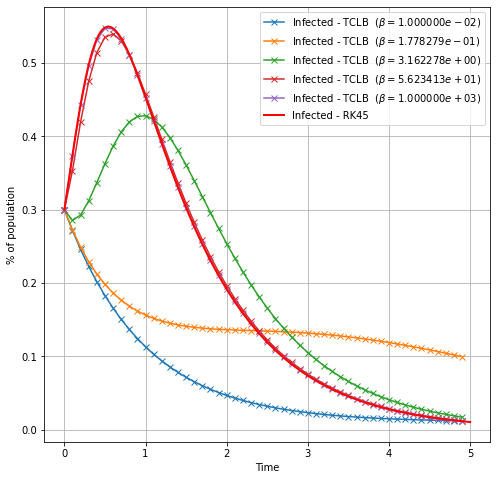

In [7]:
plt.figure(figsize=(8,8))
    
for _beta in np.logspace(-5,0,5):
    
    CLBc = CLBXML.CLBConfigWriter( )

    CLBc.addGeomParam('nx', 1)
    CLBc.addGeomParam('ny', 1)


    params = {
            "Diffusivity_W" : 1./6.,
            "Beta_w": (_beta / dt) * dt,
            "Beta":Beta * dt,
            "Gamma":Gamma * dt,            
            "Init_W":0, #No initial "Virial Load"
            "Init_S":S_init,
            "Init_I":I_init,
            "Init_R":R_init,
            "Init_N":1
    }

    CLBc.addModelParams(params)


    CLBc.addHDF5()
    solve = CLBc.addSolve(iterations=T_lbm)
    CLBc.addHDF5(Iterations=SaveEvery, parent=solve)

    CLBc.write('WSIR-UniformIC-iterBeta.xml')

    ! rm -rf output/* &&  tclb d2q9_reaction_diffusion_system_SIR_ModifiedPeng WSIR-UniformIC-iterBeta.xml > /dev/null && echo "DONE!"


    S = list()
    I = list()
    R = list()
    t_lb = list()
    for i in range(0,T_lbm,SaveEvery):
        f = h5py.File('output/WSIR-UniformIC-iterBeta_HDF5_%08d.h5'%i)    
        #plt.plot(f['DRE_1'][0,25,:])
        S.append( f['S'][0,0,0] )
        I.append( f['I'][0,0,0] )
        R.append( f['R'][0,0,0] )
        t_lb.append(i)

    t_lb = np.array(t_lb)*dt

    plt.plot(t_lb,I, '-x', label=r'Infected - TCLB  ($\beta=%e$)'%(_beta/dt) )

plt.plot(t_rk4, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='Infected - RK45')

plt.legend()
plt.grid(which='both')
plt.xlabel('Time')
plt.ylabel('% of population')

# SIR - Simple Laplace
The same could be done with SIR_SimpleLaplace model - for large $\beta$ results are identical

Hello allocator!
DONE!


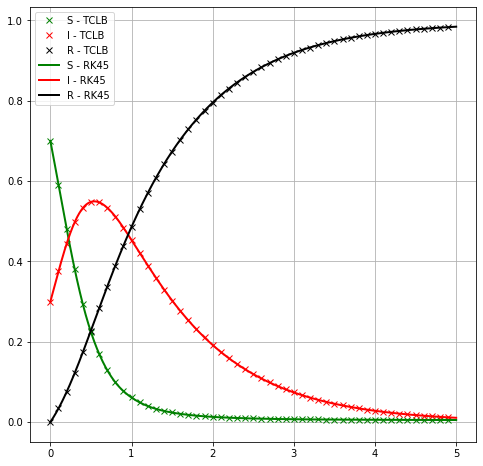

In [8]:


CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', 5)
CLBc.addGeomParam('ny', 5)


params = {
        "Diffusivity_S" : 1./6.,
        "Diffusivity_I" : 1./6.,
        "Diffusivity_R" : 1./6.,    
        "Beta":Beta*dt,
        "Gamma":Gamma*dt, 
        "Init_S":S_init,
        "Init_I":I_init,
        "Init_R":R_init
}

CLBc.addModelParams(params)


CLBc.addHDF5()
solve = CLBc.addSolve(iterations=T_lbm)
CLBc.addHDF5(Iterations=SaveEvery, parent=solve)

CLBc.write('SIRwithDiffusion.xml')

! rm -rf output/* &&  tclb d2q9_reaction_diffusion_system_SIR_SimpleLaplace SIRwithDiffusion.xml > /dev/null && echo "DONE!"


S = list()
I = list()
R = list()
t_lb = list()
for i in range(0,T_lbm,SaveEvery):
    f = h5py.File('output/SIRwithDiffusion_HDF5_%08d.h5'%i)    
    #plt.plot(f['DRE_1'][0,25,:])
    S.append( f['S'][0,0,0] )
    I.append( f['I'][0,0,0] )
    R.append( f['R'][0,0,0] )
    t_lb.append(i)

t_lb = np.array(t_lb)*dt

    
    
plt.figure(figsize=(8,8))
    
plt.plot(t_lb,S, 'gx', label='S - TCLB')
plt.plot(t_lb,I, 'rx', label='I - TCLB')
plt.plot(t_lb,R, 'kx', label='R - TCLB')

plt.plot(t_rk4, S_rk4,
         color="green", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='S - RK45')
plt.plot(t_rk4, I_rk4,
         color="red", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='I - RK45')
plt.plot(t_rk4, R_rk4,
         color="black", marker="", markevery=1, markersize=15, linestyle="-", linewidth=2,
         label='R - RK45')
plt.legend()

plt.grid(which='both')
